# Exploratory Work<br>
Mira Welner

April 22, 2024

In [1]:
import regex as re
import pickle
from itertools import combinations
from tqdm import tqdm
import requests
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIRM.PIRMDiscovery import CT_From_Table, Screen
from scipy.stats import ttest_ind
to_name = pd.read_csv('translator.csv').set_index('gene_num')['gene_name'].to_dict()
to_ensembl = pd.read_csv('translator.csv').set_index('gene_name')['gene_num'].to_dict()
genes_from_paper = [string.strip() for string in open('genes_from_papers.txt', 'r').readlines()]
genes_we_have = pd.read_csv('counts.csv')['Unnamed: 0'].tolist()
genes = [to_ensembl[x] for x in genes_from_paper if to_ensembl[x] in genes_we_have]
counts = np.log1p(pd.read_csv("pe-rna.counts.txt", index_col=0)).loc[genes,:]
meta = pd.read_csv("pe-rna-metadata.csv", header=None, names=["sample", "classification"])
mild = counts[meta.loc[meta['classification'] == 'Mild', 'sample'].tolist()]
severe = counts[meta.loc[meta['classification'] == 'Severe', 'sample'].tolist()]
control = counts[meta.loc[meta['classification'] == 'Control', 'sample'].tolist()]

## Part 1: PIRM on genes with shared pathways vs PIRM on genes without shared pathways

The following function determines, given a pair of genes, if they share any pathways and if so, what are they?

In [2]:
def pathways_in_common(pair):
    gene1, gene2 = pair
    pattern = r'"name":"(.*?)","dataSource":'
    gene_1_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+to_name[gene1]).text)
    gene_2_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+to_name[gene2]).text)
    if gene_1_pathways == [] and gene_2_pathways == []:
        return -1
    return [value for value in gene_1_pathways if value in gene_2_pathways]

First, we create two groups, A and B. A has every pair for which the two genes, (G1,G2), share a pathway. B has every pair for which (G1,G2) have no pathways in common. It takes over 20 minutes to create the lists so I pickled them

In [3]:
"""
A = []
A_lengths = []
B = []
pairs = list(combinations(genes, 2))
for pair in tqdm(pairs):
    pathways = pathways_in_common(pair)
    if pathways != -1 and len(pathways):
        A.append(pair)
        A_lengths.append(len(pathways))
    else:
        B.append(pair)
with open('A_B.pkl', 'wb') as f:
    pickle.dump((A,B,A_lengths), f)
"""
with open('A_B.pkl', 'rb') as f:
   A,B,A_lengths = pickle.load(f)
print(len(A))
print(len(B))

167
2759


As you predicted, A is indeed much smaller than B

Now we run each pair through PIRM

In [4]:
def PIRM_accuracy(case, control, pairs):
    all_pair_accuracies = []
    ct_case = CT_From_Table(sample_ids = case.columns, group_label = 'case',  table=case.T)
    ct_ctrl = CT_From_Table(sample_ids = control.columns, group_label = 'control',  table=control.T)
    for pair in pairs:
        correct, incorrect = (0,0)
        s = Screen(name='s', ct_case=ct_case, ct_ctrl=ct_ctrl, pair=list(pair))
        for ct in [ct_case, ct_ctrl]:
            for _, sample in ct.ctp.iterrows():
                if s.classify(pd.DataFrame(sample).T)['pred'] == ct.group_label:
                    correct += 1
                else:
                    incorrect += 1
        all_pair_accuracies.append(correct/(correct+incorrect))
    return all_pair_accuracies

And create the following histograms

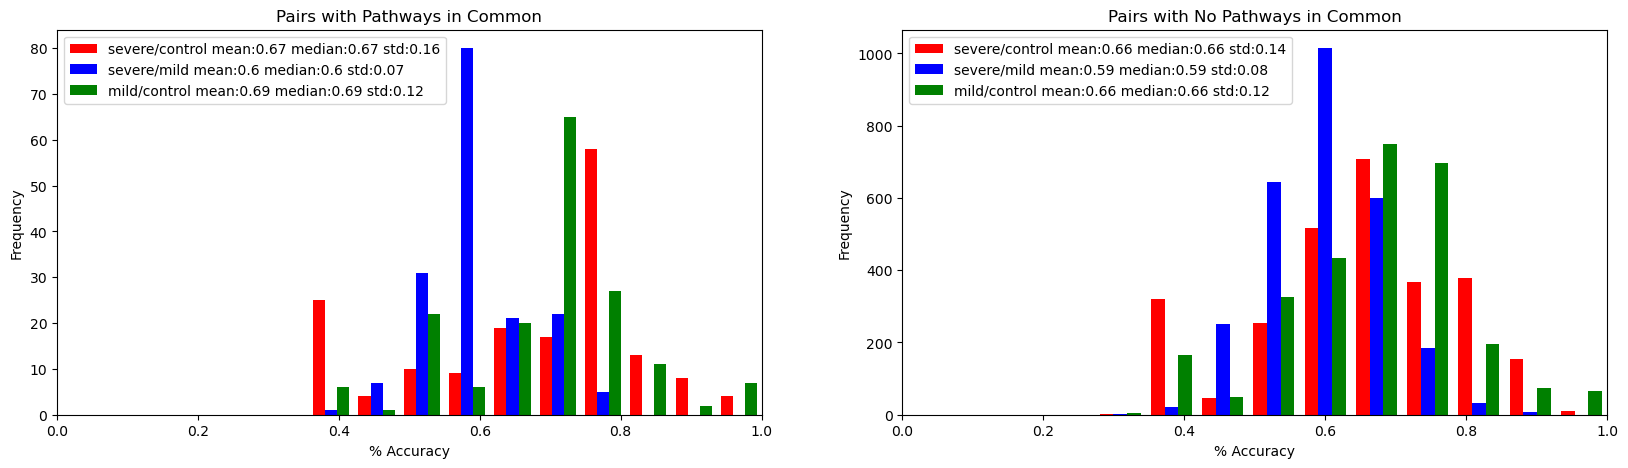

In [5]:
A_sc = PIRM_accuracy(severe, control, A)
B_sc = PIRM_accuracy(severe, control, B)
A_sm = PIRM_accuracy(severe, mild, A)
B_sm = PIRM_accuracy(severe, mild, B)
A_mc = PIRM_accuracy(mild, control, A)
B_mc = PIRM_accuracy(mild, control, B)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
l = [
    f"severe/control mean:{np.round(np.mean(A_sc),2)} median:{round(np.mean(A_sc),2)} std:{np.round(np.std(A_sc),2)}",
    f"severe/mild mean:{np.round(np.mean(A_sm),2)} median:{round(np.mean(A_sm),2)} std:{np.round(np.std(A_sm),2)}",
    f"mild/control mean:{np.round(np.mean(A_mc),2)} median:{round(np.mean(A_mc),2)} std:{np.round(np.std(A_mc),2)}",
]
ax1.hist((A_sc, A_sm, A_mc), color=["red", "blue", "green"], label=l)
ax1.set_title("Pairs with Pathways in Common")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 1)
ax1.set_xlabel("% Accuracy")
ax1.set_ylabel("Frequency")
l = [
    f"severe/control mean:{np.round(np.mean(B_sc),2)} median:{round(np.mean(B_sc),2)} std:{np.round(np.std(B_sc),2)}",
    f"severe/mild mean:{np.round(np.mean(B_sm),2)} median:{round(np.mean(B_sm),2)} std:{np.round(np.std(B_sm),2)}",
    f"mild/control mean:{np.round(np.mean(B_mc),2)} median:{round(np.mean(B_mc),2)} std:{np.round(np.std(B_mc),2)}",
]
ax2.hist((B_sc, B_sm, B_mc), color=["red", "blue", "green"], label=l)
ax2.set_title("Pairs with No Pathways in Common")
ax2.legend(loc="upper left")
ax2.set_xlim(0, 1)
ax2.set_xlabel("% Accuracy")
ax2.set_ylabel("Frequency")
plt.savefig("histograms.png")
plt.show()

Severe vs Control T Test

In [6]:
ttest_ind(A_sc, B_sc)

TtestResult(statistic=1.3905234105239337, pvalue=0.16447581674032996, df=2924.0)

Mild vs Control T Test

In [7]:
ttest_ind(A_mc, B_mc)

TtestResult(statistic=2.840110300663037, pvalue=0.004540971068897001, df=2924.0)

Mild vs Severe T Test

In [8]:
ttest_ind(A_sm, B_sm)

TtestResult(statistic=1.1925042294592458, pvalue=0.23316035669809818, df=2924.0)

## Part 2: Explore numbers of pathways per gene

First we plot each pair on a scatterplot, comparing the number of pathways it has to the accuracy of the PIRM run. A jitter function is used due to overlap

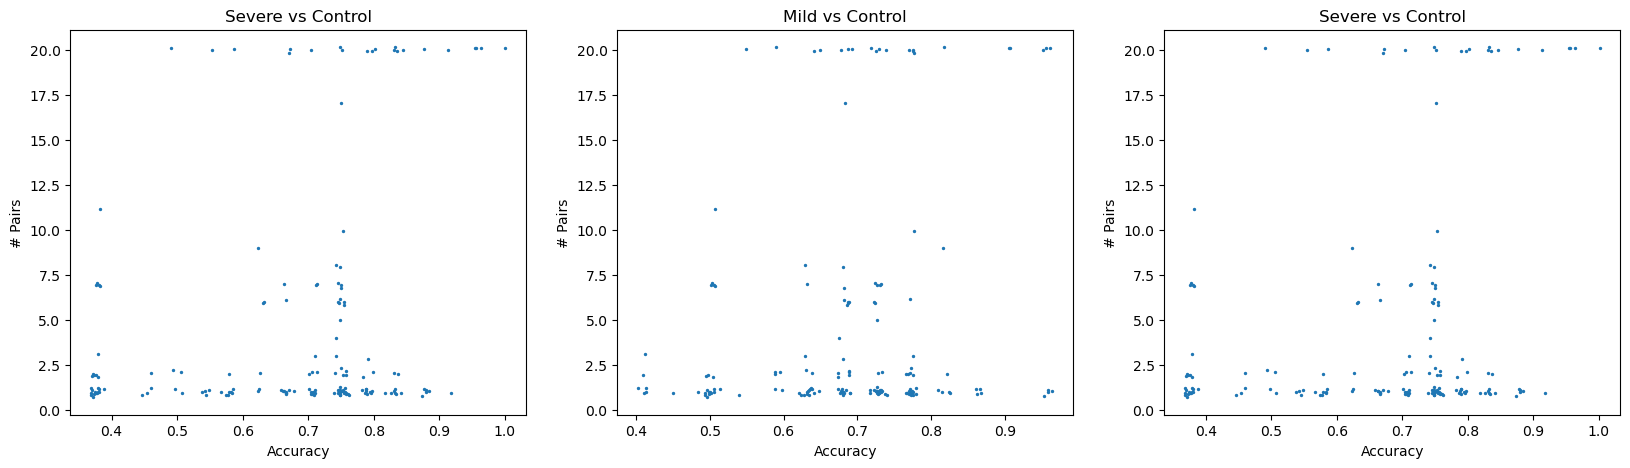

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
xjitter = np.random.normal(0, 0.005, len(A_lengths))
yjitter = np.random.normal(0,0.1, len(A_lengths))

ax1.scatter(x=A_sc + xjitter, y=A_lengths + yjitter, s=2)
ax1.set_title("Severe vs Control")
ax1.set_ylabel("# Pairs")
ax1.set_xlabel("Accuracy")

ax2.scatter(x=A_mc + xjitter, y=A_lengths+yjitter, s=2)
ax2.set_title("Mild vs Control")
ax2.set_ylabel("# Pairs")
ax2.set_xlabel("Accuracy")

ax3.scatter(x=A_sc + xjitter, y=A_lengths+yjitter, s=2)
ax3.set_title("Severe vs Control")
ax3.set_ylabel("# Pairs")
ax3.set_xlabel("Accuracy")
plt.show()


The following dictionary d has a key for every gene and the values are lists which representing how many pathways the gene has in common with other genes. For example, if the key G1 has the value [1,20,12] then the gene G1 shares one pathway with G2, 20 pathways with G3, and 12 pathways with G4

In [10]:
pathway_table = pd.DataFrame(A, columns=['G1', 'G2'])
pathway_table.insert(2, "pathways", A_lengths, True)
d = {key: [] for key in genes}
def update_dict(row):
    d[row['G1']].append(row['pathways'])
    d[row['G2']].append(row['pathways'])
pathway_table.apply(update_dict, axis=1)
print(d['ENSG00000213741'])
print(d['ENSG00000278637'])
print(d['ENSG00000113761'])

[20, 20, 20, 20, 20, 20]
[1, 1]
[]


The following list is all the genes in order of how many total pathways they have from most to fewest pathways. Genes with no shared pathways are removed

In [11]:
filtered = {k: v for k, v in d.items() if v}
sorted_keys = sorted(filtered.keys(), key=lambda x: sum(filtered[x]), reverse=True)
print(np.array([to_name[key] for key in sorted_keys]))

['RPS29' 'RPL17' 'RPL23' 'RPL26' 'RPL27' 'RPL31' 'RPL34' 'LEP' 'TNF'
 'VEGFA' 'IGF1' 'IGF2' 'NFKBIA' 'INHBA' 'LYN' 'SERPINE1' 'NOS3' 'FN1'
 'BHLHE40' 'FLT1' 'EPHX1' 'GST1' 'HK2' 'NDRG1' 'UBC' 'NPM1' 'PLIN2' 'CSF1'
 'H19' 'GSTP1' 'IGF2R' 'APOE' 'IL4R' 'CCL5' 'HPSE' 'FPR3' 'NRIP1' 'MTHFR'
 'EEF1A1' 'HIST1H4A' 'C1QA' 'C1QB' 'SH3BP5' 'ACE']


Here is a histogram of the total number of pathways a gene shares all other genes in the graph

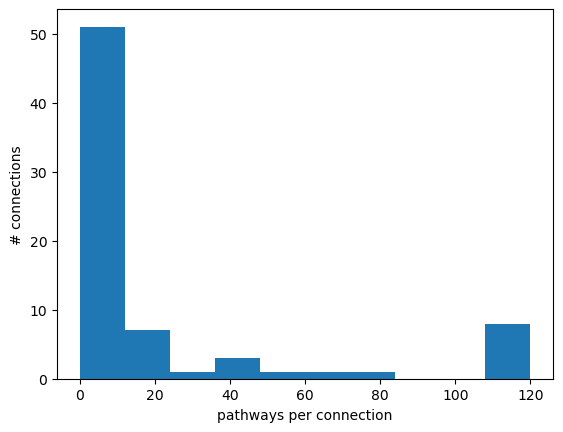

In [12]:
sums = [sum(values) for values in d.values()]
plt.hist(sums, bins=10)
plt.xlabel('pathways per connection')
plt.ylabel('# connections')
plt.show()

However this list in order is a bit misleading because if a gene has 20 pathways in common with G1 and 20 pathways in common with G2, the total pathways will be 40. However if it shares 10 pathways with G1, 10 with G2, 5 with G3 and 15 with G4, it's total pathways will also be 40. So while this ordering is technically accurate it lacks precision. The following function creates a histogram for each gene which displays how many connections they have with other genes, and how many pathways in each connection

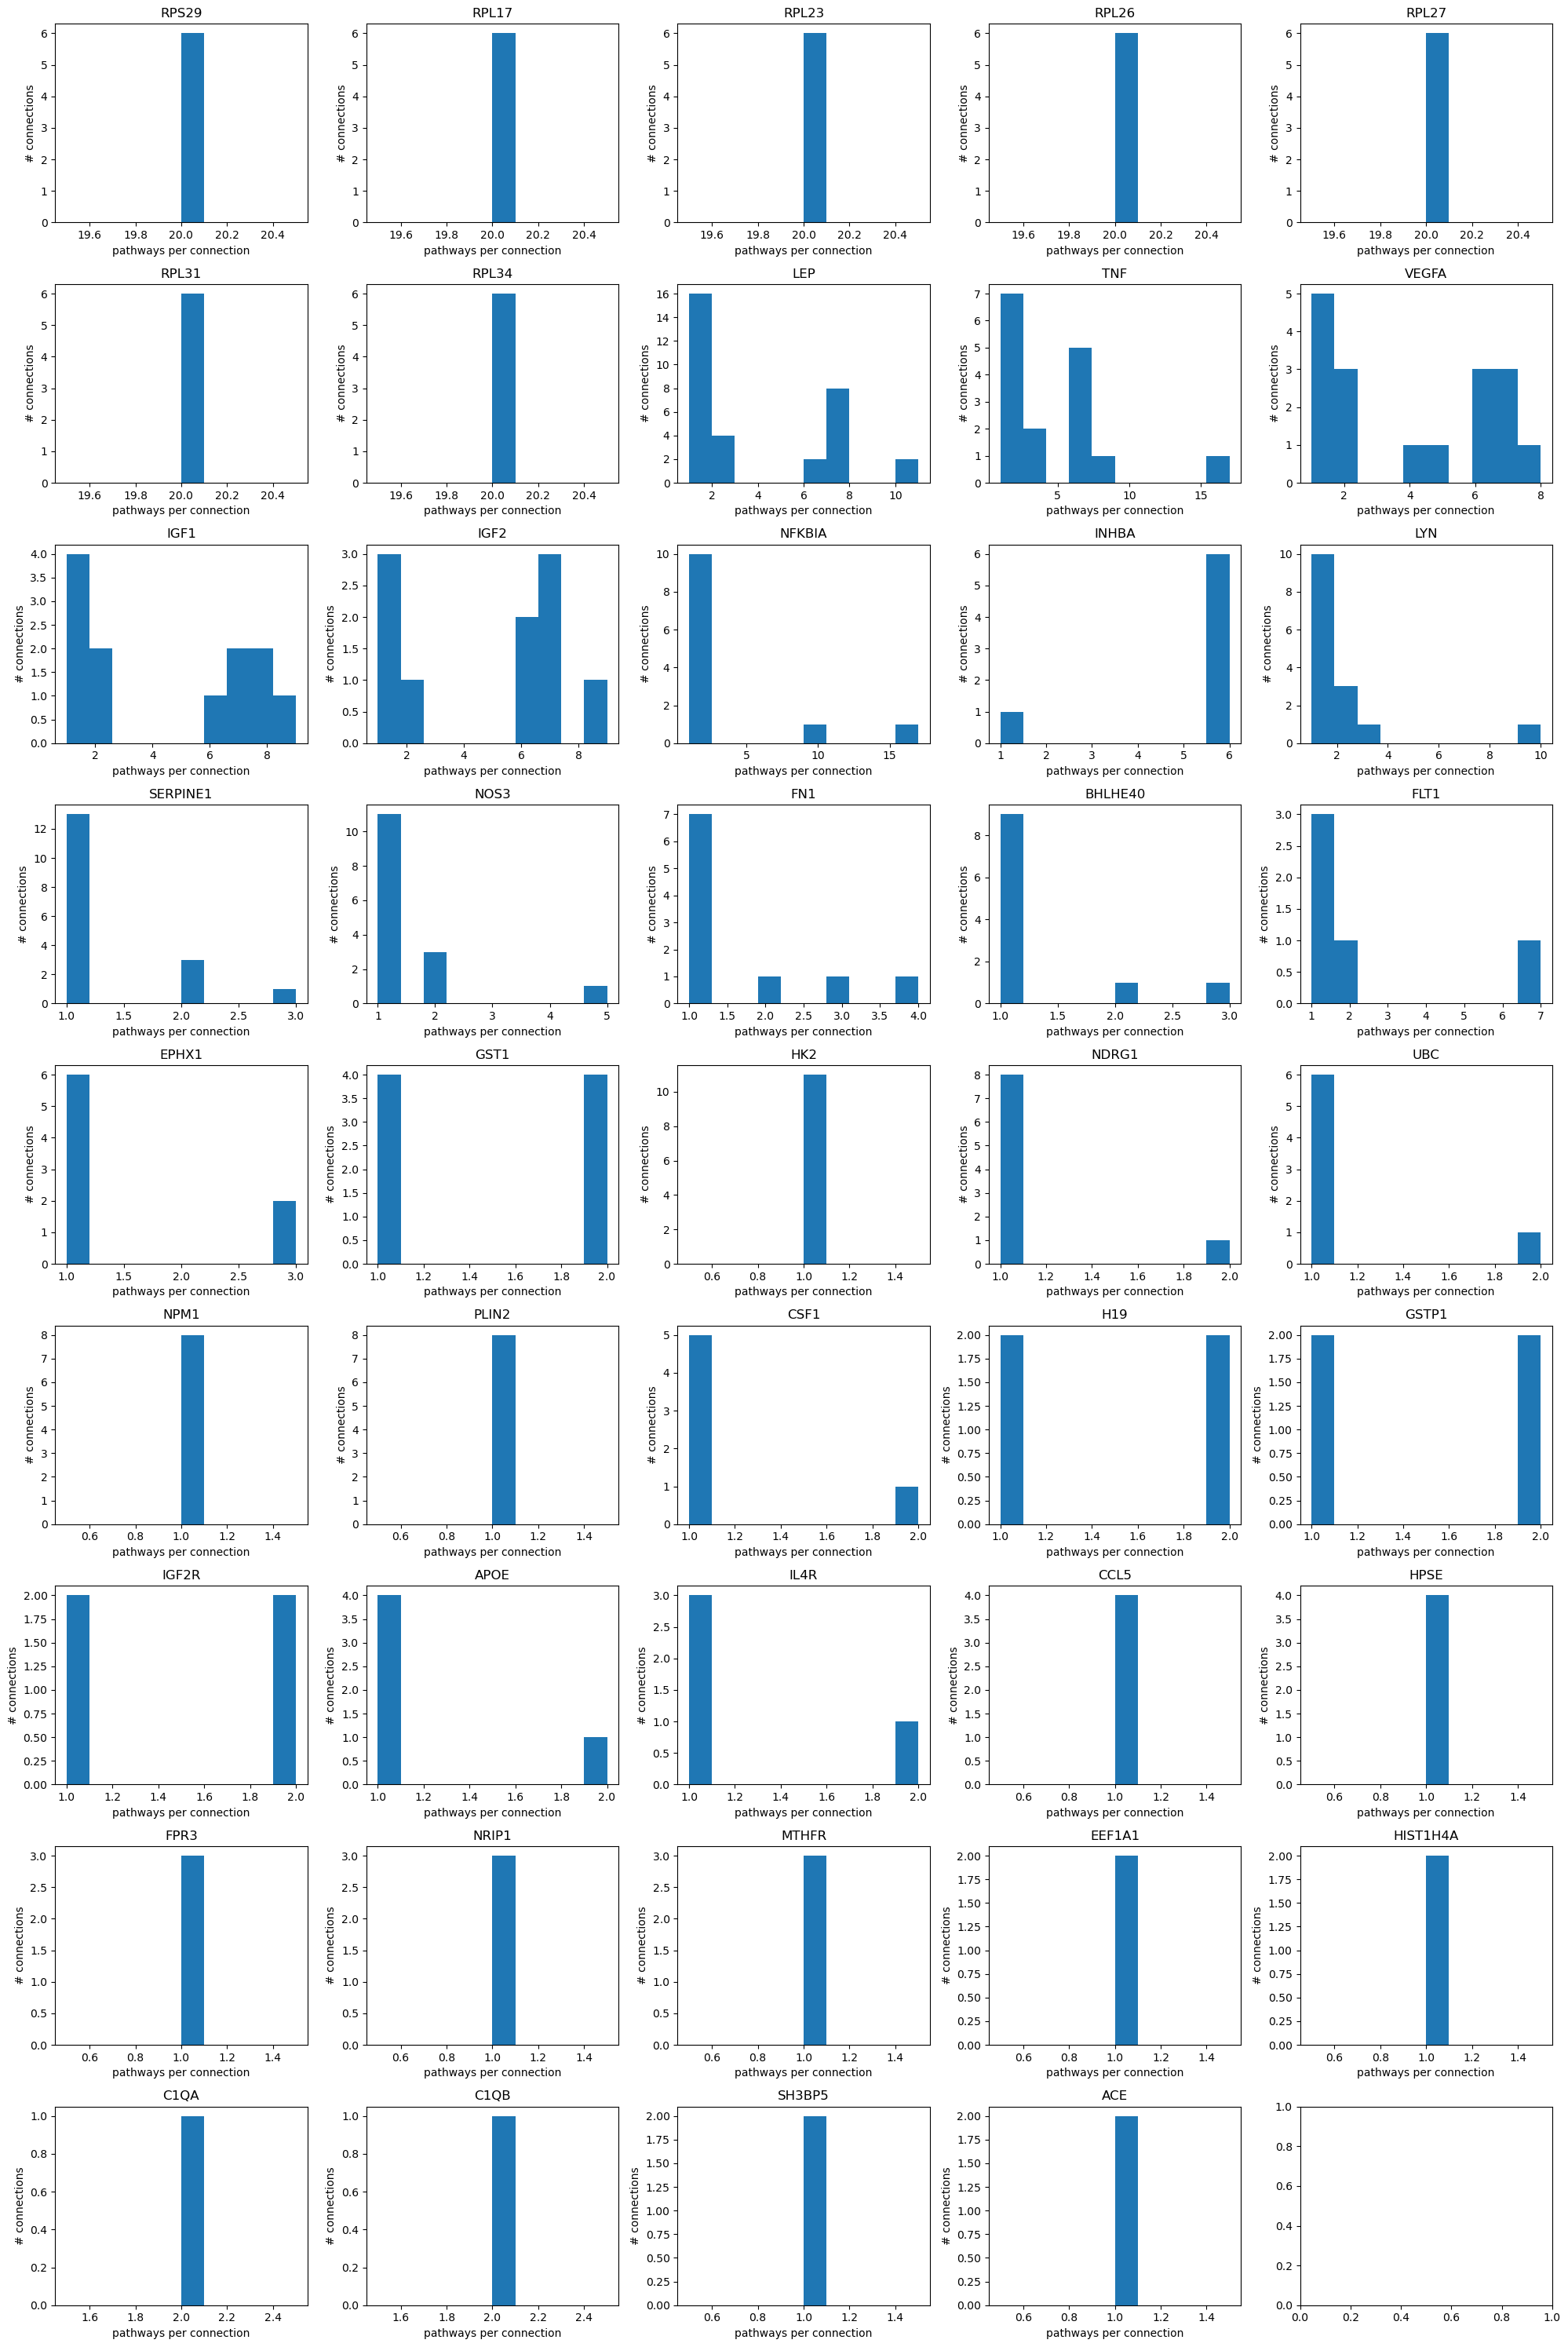

In [13]:
fig, axes = plt.subplots(len(sorted_keys)//5+1, 5, figsize=(20, 30))
for i, key in enumerate(sorted_keys):
    axes[i//5, i%5].hist(d[key])
    axes[i//5, i%5].set_title(to_name[key])
    axes[i//5, i%5].set_xlabel('pathways per connection')
    axes[i//5, i%5].set_ylabel('# connections')
fig.tight_layout()
plt.show()